# Document cropping

In this work I want to implement a simple model which can crop the documents.

## Dataset

The dataset is available on [yandex-disc](https://disk.yandex.ru/d/8ZxmzGCbgfe5OQ).

In [1]:
# uncomment if uninstalled
# !pip install shapely

In [2]:
# uncomment if uninstalled
# !pip install opencv-python

In [3]:
from pathlib import Path
from course_intro_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [4]:
plt.style.use('dark_background')

In [5]:
ds_pt = Path().absolute().parent.parent / "midv500_compressed"
assert ds_pt.exists(), ds_pt.absolute()
print(ds_pt)

/home/mchlkrpch/Documents/hw/midv500_compressed


In [6]:
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(ds_pt)
print(len(data_packs), type(data_packs[0]))

50 <class 'course_intro_ocr_t1.data.MidvPackage'>


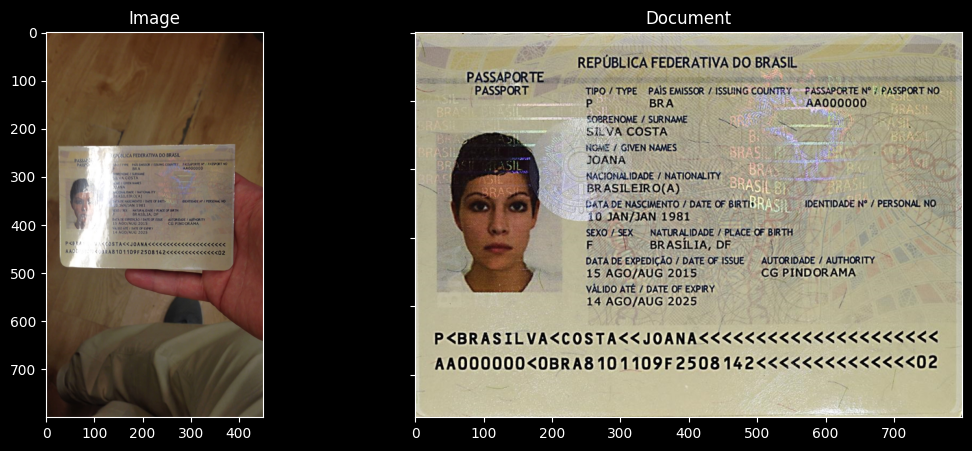

In [7]:
idx = 16
img, doc = data_packs[idx][0].image, data_packs[idx].template_item.image

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax1.set_title(f"Image")
ax1.imshow(img)

ax2.set_title(f"Document")
ax2.imshow(doc)
ax2.set_yticklabels(())

fig.subplots_adjust(wspace=-0.15)
plt.show()

In [9]:
sift = cv2.SIFT_create()
img_gray = cv2.cvtColor(np.array(img), cv2.IMREAD_GRAYSCALE)
doc_gray = cv2.cvtColor(np.array(doc), cv2.IMREAD_GRAYSCALE)
key_points1, d1 = sift.detectAndCompute(img_gray, None)
key_points2, d2 = sift.detectAndCompute(doc_gray, None)

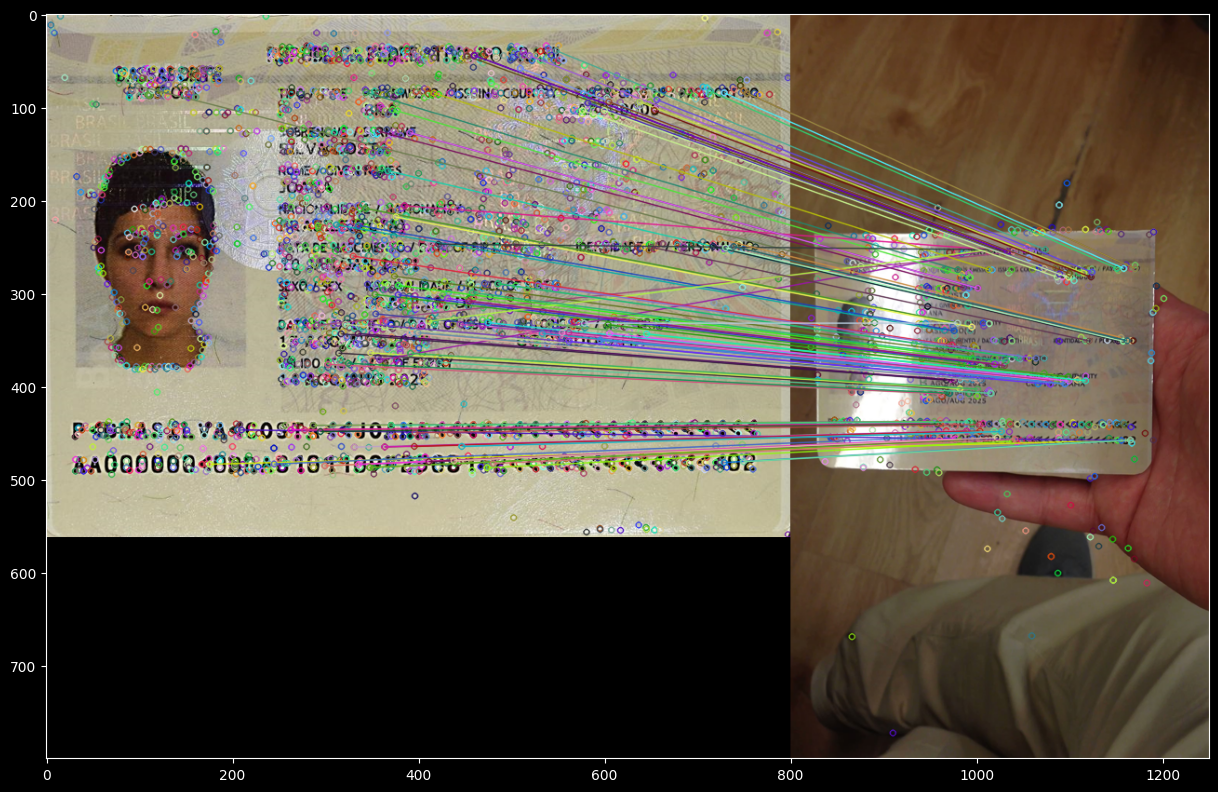

In [350]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
matched = cv2.FlannBasedMatcher(dict(algorithm=0, trees=5), dict(checks=50)).knnMatch(d2, d1, k=2)

small_dist=[]

for m, n in matched:  
    if m.distance < 0.6 * n.distance: 
        small_dist.append([m])

final_img = cv2.drawMatchesKnn(doc_gray, key_points2, img_gray, key_points1, small_dist, None)
ax1.imshow(final_img)
plt.show()

In [11]:
print(key_points2[2].pt)

(8.493412971496582, 20.80198860168457)


In [12]:
doc_ps = np.expand_dims(np.float32([key_points2[p.queryIdx].pt for [p] in good_points_for_draw]), 1)
img_ps = np.expand_dims(np.float32([key_points1[p.trainIdx].pt for [p] in good_points_for_draw]), 1)
print(doc_ps.shape)
    
matrix, mask = cv2.findHomography(doc_ps, img_ps, method=cv2.RANSAC)

(153, 1, 2)


In [13]:
points = [[0, 0], [doc_gray.shape[1], 0], [doc_gray.shape[1], doc_gray.shape[0]], [0, doc_gray.shape[0]]]
points = np.expand_dims(
    np.float32(points),
    1
)
transformed = cv2.perspectiveTransform(points, matrix)
transformed = transformed / np.array([img_gray.shape[1], img_gray.shape[0]])

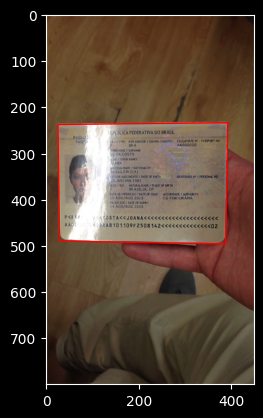

In [14]:
result = transformed.reshape(transformed.shape[0], transformed.shape[2])
data_packs[idx][0].show(result)

In [351]:
# Uses the FlannBasedMatcher function 
def match_points(d1, d_doc, koeff=0.6):
    matches = cv2.FlannBasedMatcher(dict(algorithm=0, trees=5), dict(checks=50)).knnMatch(d_doc, d1, k=2)
    distances = np.array([m.distance for m, n in matches])    
    return [matches[i][0] for i in np.where(distances < koeff * np.roll(distances, -1))[0]]

# Apply the transformation to the frame
def calc_transform(doc_img, img, mtx):
    height_quad, width_quad, _ = np.array(doc_img).shape
    points = [[0, 0], [width_quad, 0], [width_quad, height_quad], [0, height_quad]]    
    dst = cv2.perspectiveTransform(np.float32(points).reshape(-1, 1, 2) , mtx)
    return np.array(img).shape, dst

def get_frame(doc_img, img, koeff=0.6):    
    img_processed = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    kp_doc, d_doc = sift.detectAndCompute(np.array(doc_img), None)
    kp_img, d_img = sift.detectAndCompute(img_processed,     None)
    matches = cv2.FlannBasedMatcher(dict(algorithm=0, trees=5), dict(checks=50)).knnMatch(d_doc, d_img, k=2)    
    
    matched = match_points(d_img, d_doc)
    doc_ps = np.float32([kp_doc[m.queryIdx].pt for m in matched]).reshape(-1, 1, 2) 
    img_ps = np.float32([kp_img[m.trainIdx].pt for m in matched]).reshape(-1, 1, 2) 
    
    mtx, _ = cv2.findHomography(doc_ps, img_ps, cv2.RANSAC, 5.0)
    shape, dst = calc_transform(doc_img, img, mtx)
    height_img, width_img = shape[0], shape[1]

    res = dst / np.array([width_img, height_img])
    
    return res.reshape(res.shape[0], res.shape[2])

[[0.10547585 0.33944996]
 [0.86285882 0.36405464]
 [0.82391771 0.63873962]
 [0.0762293  0.59965736]]


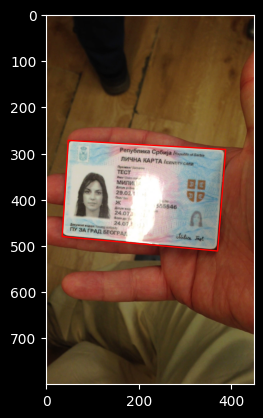

In [352]:
test_idx = 2
res = get_frame(
    data_packs[test_idx].template_item.image,
    data_packs[test_idx][0].image,
)


data_packs[test_idx][0].show(res)
print(res)

## Model

In [345]:
output_dict = dict()

for dp in tqdm(data_packs):
    # bcm = SimpleBaselineCrop(np.array(dp.template_item.image))
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                output_dict[dp[i].unique_key] = get_frame(dp.template_item.image, dp[i].image)
            except Exception as exc:
                print(exc)

100%|███████████████████████████████████████████████████████████████████| 50/50 [44:54<00:00, 53.88s/it]


In [346]:
from course_intro_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy, read_results_dict, iou_relative_quads
print(Path().absolute())
dump_results_dict(output_dict, Path().absolute() / 'pred.json')
acc = measure_crop_accuracy(
    Path().absolute() / 'pred.json',
    Path().absolute() / 'gt.json'
)
print("Точность кропа: {:1.4f}".format(acc))

/home/mchlkrpch/Documents/hw/course_intro_ocr/task1
Точность кропа: 0.9485


## Score
Let's check score without images that we pass through the model but didn't find in answers

In [349]:
gt = read_results_dict(Path().absolute() / 'gt.json')
print('32_lva_passport|ground_truth|HA|HA32_29.json' in gt)

# Example of work of the model
q1 = output_dict['32_lva_passport|ground_truth|HA|HA32_29.json']
q2 = gt['32_lva_passport|ground_truth|HA|HA32_29.json']
print(iou_relative_quads(q1,q2))

# Calculate accuracy without not found images
result = []
i = 0
for key, gt_quad in gt.items():
    if key in output_dict:
        pred_quad = output_dict[key]
        result.append(iou_relative_quads(gt_quad, pred_quad))
    else:
        i += 1
        ious.append(0)
result = np.array(result, dtype=np.float32)

acc = (result > 0.95).astype(int).sum() / (len(result) - i)
print("Result: ", acc)

True
0.9913938490429709
Result:  0.9484705882352941
